The model training script for SIFT on reduced COCO dataset

We only use top 10 classes for faster training speed

(w/out parameter selection ver)

In [1]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

In [2]:
train2017 = 'train2017'
val2017 = 'val2017'
ann_file = 'dataset/coco/annotations/instances_{}.json'

In [3]:
TOP_10_CATS_ID = set([1,  3, 62, 84, 44, 47, 67, 51, 10, 31])
CATS_NAMES = {
    1: 'person',
    3: 'car',
    62: 'chair',
    84: 'book',
    44: 'bottle',
    47: 'cup',
    67: 'dinning table',
    51: 'traffic light',
    10: 'bowl',
    31: 'handbag'
}
LABELS = [CATS_NAMES[id] for id in sorted(list(TOP_10_CATS_ID))]

In [4]:
coco_train = COCO(ann_file.format(train2017))
coco_val = COCO(ann_file.format(val2017))

loading annotations into memory...
Done (t=11.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [5]:
def get_coco_images_and_labels(coco):

    # get all filenames
    img_ids_w_filename = {coco.dataset['images'][i]['id']: coco.dataset['images'][i]['file_name'] for i in range(len(coco.dataset['images']))}      # use dictionary for faster query

    # get all images
    img_ids = [coco.dataset['images'][i]['id'] for i in range(len(coco.dataset['images']))]

    # load labels for each imgs (as one img may have multiple labels)
    labels_per_imgs = []
    for i in range(len(img_ids)):
        labels_per_imgs.append(coco.loadAnns(coco.getAnnIds(imgIds=img_ids[i])))

    img_id_w_bb = []
    label_per_obj = []

    for labels in labels_per_imgs:
        for l in labels:
            img_id_w_bb.append((l['id'], l['image_id'], l['bbox']))
            label_per_obj.append(l['category_id'])

    return img_ids_w_filename, img_id_w_bb, label_per_obj

In [6]:
img_ids_w_filename_train, img_id_w_bb_train, label_per_obj_train = get_coco_images_and_labels(coco_train)
img_ids_w_filename_val, img_id_w_bb_val, label_per_obj_val = get_coco_images_and_labels(coco_val)

In [7]:
# load filtered dataset

import pickle

filtered_dataset_dir = Path('dataset/coco_top10_filtered_20250423')

with open(filtered_dataset_dir / 'img_id_w_bb_train_top10_v2.pkl', 'rb') as f:
    img_id_w_bb_train_top10_filtered = pickle.load(f)
with open(filtered_dataset_dir / 'label_per_obj_train_top10_v2.pkl', 'rb') as f:
    label_per_obj_train_top10_filtered = pickle.load(f)

with open(filtered_dataset_dir/ 'img_id_w_bb_val_top10.pkl', 'rb') as f:
    img_id_w_bb_val_top10 = pickle.load(f)
with open(filtered_dataset_dir / 'label_per_obj_val_top10.pkl', 'rb') as f:
    label_per_obj_val_top10 = pickle.load(f)

In [8]:
len(img_id_w_bb_train_top10_filtered), len(label_per_obj_train_top10_filtered)

(62444, 62444)

In [9]:
len(img_id_w_bb_val_top10), len(label_per_obj_val_top10)

(20312, 20312)

Create train-val-test set 

Training-val has ratio 4:1; with stratify consideration

In [10]:
from sklearn.model_selection import train_test_split
# split the train set into train and val sets

X_train, X_test, y_train, y_test = train_test_split(img_id_w_bb_train_top10_filtered, label_per_obj_train_top10_filtered, test_size=0.2, random_state=42, stratify=label_per_obj_train_top10_filtered)

Resturcture the pipeline to NOT use datasets

It will just use up all harddisk space if repeatly use that :(

In [11]:
# just use a normal dictionary or list to manage the dataset

from tqdm import tqdm

# 1. First, prepare your data for the datasets library
def prepare_dataset_list(X, img_ids_w_filename):
    # Create a lightweight dictionary containing only metadata (not images)

    dataset_list = []
    
    for sample in X:
        per_img_dict = {}

        per_img_dict["image_id"] = sample[1]
        per_img_dict["bbox"] = sample[2]
        per_img_dict["file_name"] = img_ids_w_filename[sample[1]]

        dataset_list.append(per_img_dict)
        
    return dataset_list

# 2. Define the SIFT processing function

def process_image_with_sift(example, coco_ds):
    """Process a single image, extracting SIFT features"""
    # Load image only when needed
    img_path = Path(f"dataset/coco/{coco_ds}/{example['file_name']}")
    img = cv2.imread(str(img_path))
    
    # Apply bounding box
    x, y, w, h = example['bbox']
    img_cropped = img[int(y): int(y + h) + 1, int(x):int(x + w) + 1]
    
    # Convert to grayscale
    img_gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    
    # Apply SIFT
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)
    
    # Convert keypoints to serializable format
    serialized_keypoints = []
    for kp in keypoints:
        serialized_keypoints.append({
            'x': float(kp.pt[0]),
            'y': float(kp.pt[1]), 
            'size': float(kp.size),
            'angle': float(kp.angle),
            'response': float(kp.response),
            'octave': int(kp.octave)
        })
    
    # Return only the features, together with the image_id, bbox, and filename
    # but not the image (pixel) itself
    return {
        'image_id': example['image_id'],
        'bbox': example['bbox'],
        'file_name': example['file_name'],
        'keypoints': serialized_keypoints,
        'descriptors': descriptors if descriptors is not None else np.array([])
    }

def create_sift_dataset(X, coco_ds, img_ids_w_filename):
    # Create the dataset dictionary
    dataset_list_init = prepare_dataset_list(X, img_ids_w_filename)

    dataset_list = []

    with tqdm(total=len(dataset_list_init)) as pbar:
        pbar.set_description("Extracting SIFT features")

        for i, example in enumerate(dataset_list_init):
            # Process using (optional) multi-processing
            processed_example = process_image_with_sift(example, coco_ds)
            dataset_list.append(processed_example)
            pbar.update(1)

    return dataset_list

In [12]:
import pickle

sift_dataset_train_path = Path('dataset/coco_top10_filtered_20250423/sift_dataset_train.pkl')

if sift_dataset_train_path.exists():
    sift_dataset_train = pickle.load(open(sift_dataset_train_path, 'rb'))

    print("Training dataset already exists. Loading from disk...")

else:
    # Create the dataset
    sift_dataset_train = create_sift_dataset(X_train, train2017, img_ids_w_filename_train)

    # Save the dataset to disk
    # ~5.49 GB
    pickle.dump(sift_dataset_train, open(sift_dataset_train_path, 'wb'))

    print("Training dataset is created and saved to disk.")

Training dataset already exists. Loading from disk...


In [13]:
sift_dataset_test_path = Path('dataset/coco_top10_filtered_20250423/sift_dataset_test.pkl')

if sift_dataset_test_path.exists():
    sift_dataset_test = pickle.load(open(sift_dataset_test_path, 'rb'))

    print("Testing dataset already exists. Loading from disk...")

else:
    # Create the dataset
    sift_dataset_test = create_sift_dataset(X_test, train2017, img_ids_w_filename_train)

    # Save the dataset to disk
    pickle.dump(sift_dataset_test, open(sift_dataset_test_path, 'wb'))

    print("Testing dataset is created and saved to disk.")

Testing dataset already exists. Loading from disk...


In [14]:
sift_dataset_val_path = Path('dataset/coco_top10_filtered_20250423/sift_dataset_val')
if sift_dataset_val_path.exists():
    sift_dataset_val = pickle.load(open(sift_dataset_val_path, 'rb'))

    print("Validation dataset already exists. Loading from disk...")
else:
    # create the dataset
    sift_dataset_val = create_sift_dataset(img_id_w_bb_val_top10, val2017, img_ids_w_filename_val)

    # try to save the dataset
    pickle.dump(sift_dataset_val, open(sift_dataset_val_path, 'wb'))

    print("Validation dataset is created and saved to disk.")

Validation dataset already exists. Loading from disk...


In [15]:
sift_dataset_train[0]['descriptors']

array([[  0.,   0.,   0., ...,   0.,   0.,  13.],
       [125., 125.,   5., ...,  16.,  16.,  43.],
       [  0.,   0.,   0., ...,   0.,   1.,   3.],
       ...,
       [ 95., 152.,   1., ...,  68.,  21.,   1.],
       [ 81.,  27.,   1., ...,   2.,   1.,   0.],
       [141., 141.,  16., ...,   7.,  33., 111.]], dtype=float32)

In [16]:
def load_all_descriptors(sift_dataset):

    all_descriptors = []
    for example in sift_dataset:
        # check if descriptors is not empty
        if example['descriptors'].ndim < 2:
            continue

        all_descriptors.append(example['descriptors'])
    # convert to numpy array
    all_descriptors_np = np.concatenate(all_descriptors, axis=0)

    return all_descriptors_np

In [17]:
# grab all descriptors (write them to memory, as KMeans have no incremental fit)
all_descriptors_train_path = Path('dataset/coco_top10_filtered_20250423/all_descriptors_train.npy')

if all_descriptors_train_path.exists():
    all_descriptors_np_train = np.load(all_descriptors_train_path)
    
    print("All descriptors for training dataset already exists. Loading from disk...")

else:
    all_descriptors_np_train = load_all_descriptors(sift_dataset_train)
    
    # save to disk
    np.save(all_descriptors_train_path, all_descriptors_np_train)

    print("All descriptors for training dataset is created and saved to disk.")

All descriptors for training dataset already exists. Loading from disk...


In [18]:
all_descriptors_np_train.shape

(5481721, 128)

---

Model

In [19]:
DESCIPTORS_DIM = len(sift_dataset_train[0]['descriptors'][0])
DESCIPTORS_DIM

128

In [20]:
PCA_N_COMPONENTS = 20
K = 100

In [21]:
from datetime import datetime

tdy = datetime.now()
top_model_dir = Path(f'models/PCA-SIFT/{tdy.strftime("%Y%m%d-%H%M%S")}/')
if not top_model_dir.exists():
    top_model_dir.mkdir(parents=True)

---

Model

PCA-SIFT

In [22]:
# if you don't want to apply dimension reduction -> just run this cell
# otherwise, run the next cell

pca = None
all_descriptors_pca = all_descriptors_np_train

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=PCA_N_COMPONENTS)
pca.fit(all_descriptors_np_train)
# transform all descriptors
all_descriptors_pca = pca.transform(all_descriptors_np_train)

In [24]:
from sklearn.cluster import KMeans

# fit KMeans clustering
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(all_descriptors_pca)

kmean_cluster_centers = kmeans.cluster_centers_

In [25]:
# extend the dataset with the cluster id (equivalent to vector quantization)
def assign_cluster_id(example, kmeans, pca):
    """Assign cluster id to each keypoint based on the closest cluster center"""
    # Update the example with the cluster ids

    des = np.array(example['descriptors'])
    # check if descriptors are empty
    if des.size == 0:
        example['cluster_ids'] = np.array([], dtype=np.int32)
        return example
    
    # apply PCA to the descriptors
    red_des = pca.transform(des)

    # early return if transformed descriptors are empty
    if red_des.size == 0:
        example['cluster_ids'] = np.array([], dtype=np.int32)
        return example

    if red_des.ndim == 1:
        example['cluster_ids'] = kmeans.predict(red_des.reshape(1, -1))
    else:
        example['cluster_ids'] = kmeans.predict(red_des)
    
    return example

In [26]:
# Apply the filter to the dataset
with tqdm(total=len(sift_dataset_train)) as pbar:
    pbar.set_description("Assigning cluster ids to keypoints")
    for idx, example in enumerate(sift_dataset_train):
        sift_dataset_train[idx] = assign_cluster_id(example, kmeans, pca)
        pbar.update(1)

Assigning cluster ids to keypoints: 100%|██████████| 49955/49955 [01:24<00:00, 587.78it/s] 


In [27]:
# create a histogram of the cluster ids
# that will be used to compute TF-IDF

def create_histogram(example):
    """Create a histogram of cluster ids"""

    # early exit if descriptors are empty -> cluster_ids will be empty too
    if len(example['descriptors']) == 0:
        example['histogram'] = np.array([[]], dtype=np.int64)
        return example
    

    hist, _ = np.histogram(example['cluster_ids'], bins=np.arange(K + 1))
    
    example['histogram'] = hist.reshape(-1, K)

    return example

In [28]:
# Apply the histogram function to the dataset
with tqdm(total=len(sift_dataset_train)) as pbar:
    pbar.set_description("Creating histogram of cluster ids")
    for idx, example in enumerate(sift_dataset_train):
        sift_dataset_train[idx] = create_histogram(example)
        pbar.update(1)

Creating histogram of cluster ids:   0%|          | 0/49955 [00:00<?, ?it/s]

Creating histogram of cluster ids: 100%|██████████| 49955/49955 [00:00<00:00, 122590.24it/s]


Then use TF-IDF to create histogram for every image

In [29]:
# create histogram using TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

# grab all non-empty histograms and concat them to a very large 2D array
des_histo = np.concatenate(
    [example['histogram'] for idx, example in enumerate(sift_dataset_train) if len(example['histogram'][0]) > 0],
    axis=0
)
# reshape, just in case
des_histo = des_histo.reshape(des_histo.shape[0], -1)

# Convert the list of descriptors to TF-IDF representation
tfidf_matrix = tfidf_transformer.fit_transform(des_histo)

In [30]:
# note that there are images with no histograms
# need to filter them out

y_train_filtered = [y_train[idx] for idx, example in enumerate(sift_dataset_train) if len(example['histogram'][0]) > 0]
y_train_filtered = np.array(y_train_filtered)

In [31]:
tfidf_matrix.shape

(44310, 100)

In [32]:
y_train_filtered

array([44,  1, 47, ...,  3, 67,  1])

Then use a SVM classifier or SGDClassifier. The former gives slightly better performance across all classes. SGDClassifier seems faster in training. (40 min vs 2 min)

In [37]:
from sklearn.linear_model import SGDClassifier

svm_sgd = SGDClassifier(eta0=1e-3, learning_rate='constant', random_state=42, max_iter=1000, tol=1e-8, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)
svm_sgd.fit(tfidf_matrix, y_train_filtered)

SGDClassifier(early_stopping=True, eta0=0.001, learning_rate='constant',
              n_iter_no_change=10, random_state=42, tol=1e-08)

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(tfidf_matrix, y_train_filtered)

SVC(kernel='linear', probability=True, random_state=42)

In [34]:
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1, n_components=1000, random_state=42)
X_features = rbf_feature.fit_transform(tfidf_matrix)
svm_rbf = LinearSVC(tol=1e-8, random_state=42)
svm_rbf.fit(X_features, y_train_filtered)

LinearSVC(random_state=42, tol=1e-06)

In [38]:
y_train_pred = svm_sgd.predict(tfidf_matrix)

Test set

In [39]:
with tqdm(total=len(sift_dataset_test)) as pbar:
    pbar.set_description("Assigning cluster ids to keypoints")
    for idx, example in enumerate(sift_dataset_test):
        sift_dataset_test[idx] = assign_cluster_id(example, kmeans, pca)
        pbar.update(1)

with tqdm(total=len(sift_dataset_test)) as pbar:
    pbar.set_description("Creating histogram of cluster ids")
    for idx, example in enumerate(sift_dataset_test):
        sift_dataset_test[idx] = create_histogram(example)
        pbar.update(1)

Creating histogram of cluster ids: 100%|██████████| 12489/12489 [00:00<00:00, 97286.34it/s]


In [40]:
des_histo_test = np.concatenate(
    [example['histogram'] for example in sift_dataset_test if len(example['histogram'][0]) > 0],
    axis=0
)
# reshape, just in case
des_histo_test = des_histo_test.reshape(des_histo_test.shape[0], -1)

# Convert the list of descriptors to TF-IDF representation
tfidf_matrix_test = tfidf_transformer.transform(des_histo_test)

In [41]:
y_test_filtered = [y_test[i] for i, example in enumerate(sift_dataset_test) if len(example['histogram'][0]) > 0]
y_test_filtered = np.array(y_test_filtered)

In [42]:
y_test_filtered.shape

(11060,)

In [43]:
y_test_pred = svm_sgd.predict(tfidf_matrix_test)

Validation set

In [44]:
with tqdm(total=len(sift_dataset_val)) as pbar:
    pbar.set_description("Assigning cluster ids to keypoints")
    for idx, example in enumerate(sift_dataset_val):
        sift_dataset_val[idx] = assign_cluster_id(example, kmeans, pca)
        pbar.update(1)

with tqdm(total=len(sift_dataset_val)) as pbar:
    pbar.set_description("Creating histogram of cluster ids")
    for idx, example in enumerate(sift_dataset_val):
        sift_dataset_val[idx] = create_histogram(example)
        pbar.update(1)
        
des_histo_val = np.concatenate(
    [example['histogram'] for example in sift_dataset_val if len(example['histogram'][0]) > 0],
    axis=0
)
# reshape, just in case
des_histo_val = des_histo_val.reshape(des_histo_val.shape[0], -1)

# Convert the list of descriptors to TF-IDF representation
tfidf_matrix_val = tfidf_transformer.transform(des_histo_val)
y_val_filtered = [label_per_obj_val_top10[i] for i, example in enumerate(sift_dataset_val) if len(example['histogram'][0]) > 0]
y_val_filtered = np.array(y_val_filtered)

Creating histogram of cluster ids: 100%|██████████| 20312/20312 [00:00<00:00, 114455.78it/s]


In [45]:
y_val_pred = svm_sgd.predict(tfidf_matrix_val)

---

Result

In [55]:
# evaluation sub-functions
# grab accuracy score, confusion matrix, and classification report

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def compute_accuracy(y_true, y_pred):
    """Compute accuracy score"""
    return accuracy_score(y_true, y_pred)

def compute_classification_report(y_true, y_pred, labels):
    """Compute classification report"""
    return classification_report(y_true, y_pred, target_names=labels, zero_division=0)

def compute_confusion_matrix(y_true, y_pred, labels, save=False, save_path=None):
    """Compute confusion matrix"""
    cm_matrix = confusion_matrix(y_true, y_pred)

    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(11,11))
    ax.set_title('Confusion Matrix')
    cm_disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)

    if save:
        if save_path is None:
            raise ValueError("save_path must be provided if save is True")
        plt.savefig(save_path)

In [56]:
target_names = [c for c in CATS_NAMES.values()]

Get result of train set

Train accuracy:  0.3695554051004288

               precision    recall  f1-score   support

       person       0.40      0.83      0.54     14248
          car       0.26      0.18      0.21      5429
         bowl       0.28      0.16      0.20      2305
      handbag       0.00      0.00      0.00      1145
       bottle       0.18      0.05      0.08      3908
          cup       0.10      0.00      0.00      2567
traffic light       0.15      0.02      0.04      2606
        chair       0.21      0.07      0.10      4324
dinning table       0.08      0.02      0.03      2372
         book       0.39      0.49      0.44      5406

     accuracy                           0.37     44310
    macro avg       0.21      0.18      0.16     44310
 weighted avg       0.28      0.37      0.29     44310





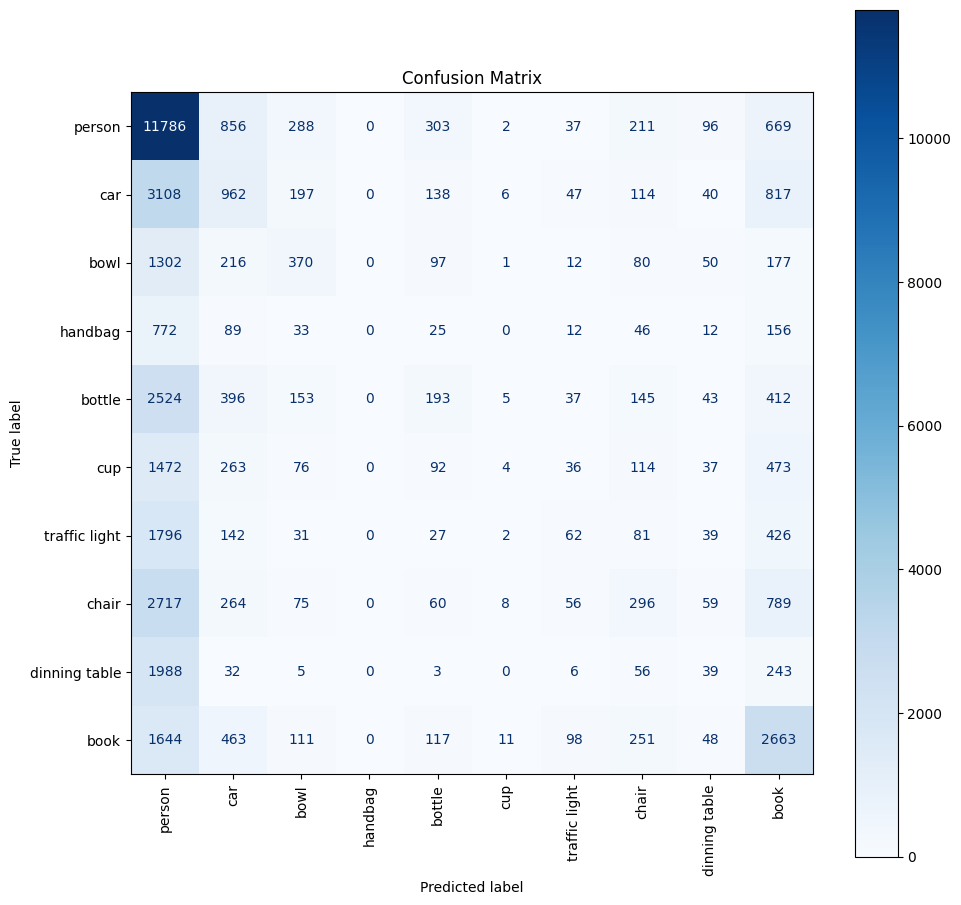

In [57]:
print("Train accuracy: ", compute_accuracy(y_train_filtered, y_train_pred)); print()

report_train = compute_classification_report(y_train_filtered, y_train_pred, labels=LABELS)
print(report_train); print(); print()

compute_confusion_matrix(y_train_filtered, y_train_pred, labels=LABELS)

Get result of test set

Test accuracy:  0.3650994575045208

               precision    recall  f1-score   support

       person       0.40      0.82      0.54      3534
          car       0.24      0.17      0.20      1359
         bowl       0.32      0.19      0.24       592
      handbag       0.00      0.00      0.00       291
       bottle       0.15      0.04      0.07       983
          cup       0.12      0.00      0.00       640
traffic light       0.12      0.02      0.03       655
        chair       0.20      0.06      0.09      1079
dinning table       0.07      0.01      0.02       596
         book       0.40      0.51      0.45      1331

     accuracy                           0.37     11060
    macro avg       0.20      0.18      0.16     11060
 weighted avg       0.27      0.37      0.28     11060





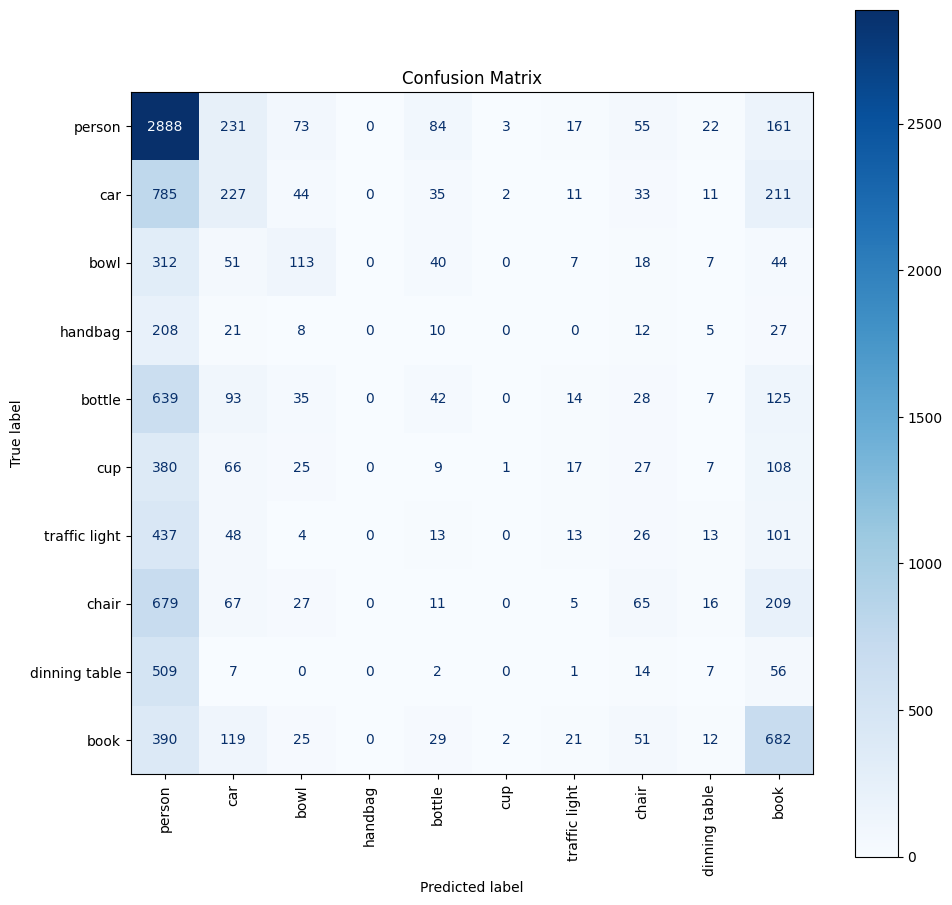

In [58]:
print("Test accuracy: ", compute_accuracy(y_test_filtered, y_test_pred)); print()

report_test = compute_classification_report(y_test_filtered, y_test_pred, labels=LABELS)
print(report_test); print(); print()

compute_confusion_matrix(y_test_filtered, y_test_pred, labels=LABELS)

Get result of evaluation set

Eval accuracy:  0.5148136000874604

               precision    recall  f1-score   support

       person       0.64      0.83      0.72     10169
          car       0.20      0.18      0.19      1664
         bowl       0.16      0.19      0.17       459
      handbag       0.00      0.00      0.00       463
       bottle       0.07      0.03      0.04       936
          cup       0.07      0.00      0.00       826
traffic light       0.11      0.03      0.04       585
        chair       0.22      0.07      0.10      1643
dinning table       0.08      0.02      0.03       670
         book       0.22      0.47      0.30       879

     accuracy                           0.51     18294
    macro avg       0.18      0.18      0.16     18294
 weighted avg       0.42      0.51      0.45     18294





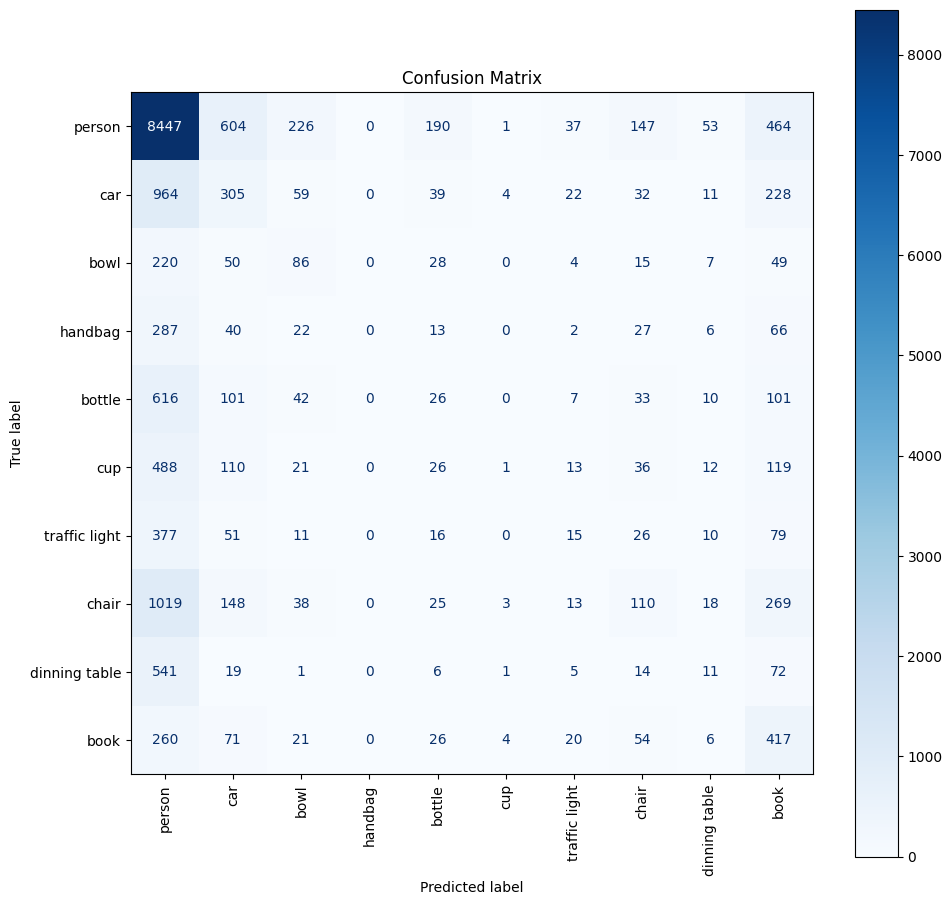

In [59]:
print("Eval accuracy: ", compute_accuracy(y_val_filtered, y_val_pred)); print()

report_val = compute_classification_report(y_val_filtered, y_val_pred, labels=LABELS)
print(report_val); print(); print()

compute_confusion_matrix(y_val_filtered, y_val_pred, labels=LABELS)